In [1]:
import keras
from keras.optimizers import rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
from keras import backend as K

import scipy.ndimage as im

import numpy as np

import h5py

import tensorflow as tf

import utils
reload(utils)

%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size = 10

data_root = '../data/tu-berlin/sample50/'
train_data_dir = data_root + 'train'
validation_data_dir = data_root + 'test'


def enhance_edges(img):
    k = np.ones((3,3))
    k[1,1] = 4.0
            
    img = np.squeeze(img)    
    factor = 1.0/img.max()
    img = img * factor
    for _ in xrange(3):
        img[img < 0.8] = 0.0
        img = im.convolve(img, k, mode='constant', cval=1.0)
        factor = 1.0/img.max()
        img = img * factor


    img = np.expand_dims(img, axis=2)
    return img

train_datagen = ImageDataGenerator(
        shear_range=0.25,
        zoom_range=0.25,
        rotation_range=35,
        horizontal_flip=True,
        preprocessing_function=enhance_edges)

test_datagen = ImageDataGenerator(preprocessing_function=enhance_edges)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

batch, y = train_generator.next()
img_height = batch.shape[1]
img_width = batch.shape[2]
channels = batch.shape[3]
num_classes = len(y[0])
print img_height, img_width, channels, num_classes

Found 2650 images belonging to 50 classes.
Found 1350 images belonging to 50 classes.
256 256 1 50


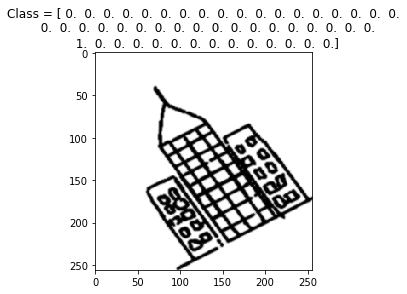

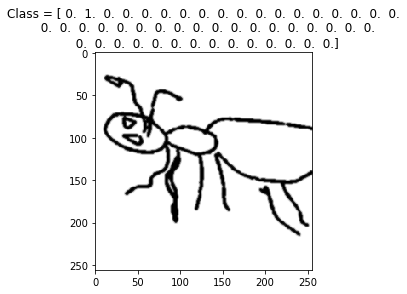

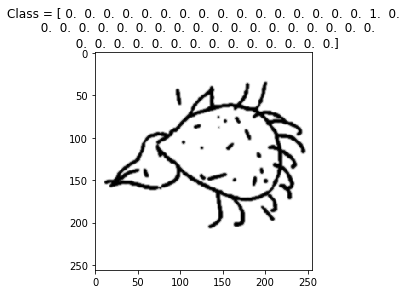

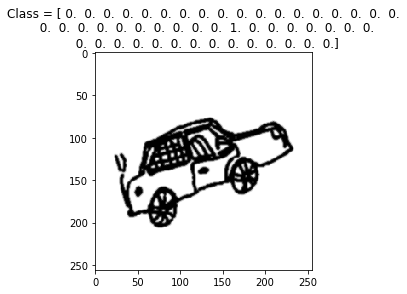

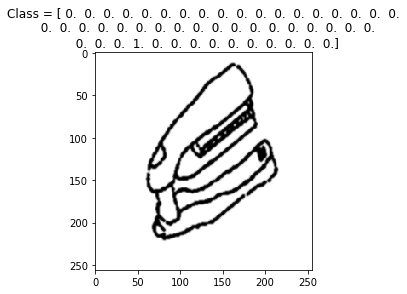

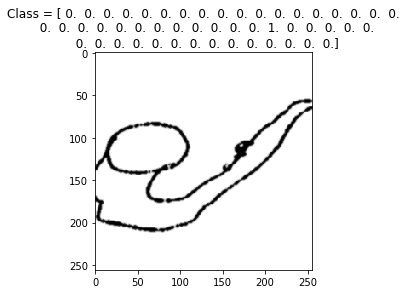

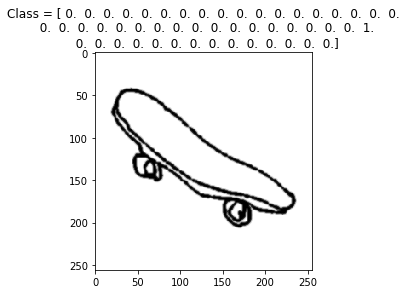

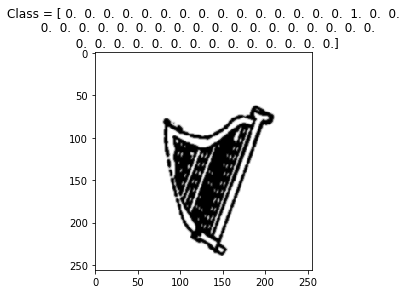

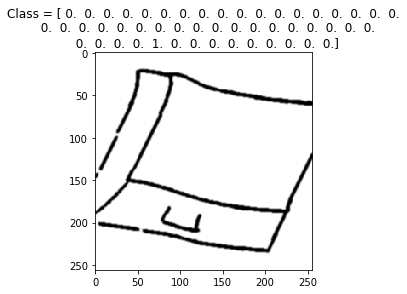

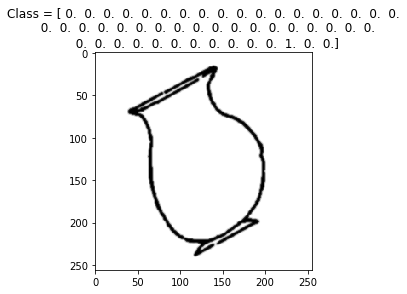

In [3]:
for img, label in zip(batch, y):
    utils.show_sample(img, label)

In [7]:
model = keras.models.load_model('../models/sketchnet4_2/latest.h5')
for i in xrange(5):
    model.pop()
    
model.add(Convolution2D(256, (3, 3), 
                        padding='same', 
                        activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3, 3), 
                        padding='same', 
                        activation='relu'))
model.add(Convolution2D(512, (3, 3), 
                        padding='same', 
                        activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 256)       295168    
__________

In [10]:
model.load_weights('../models/sketchnet4_4/latest.h5')

for i, layer in enumerate(model.layers):
    layer.name = 'layer'+str(i)
    
with open('../models/sketchnet4_4/model.json', 'w') as f:
    f.write(model.to_json())

opt = rmsprop(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [9]:
model = None
with open('../models/sketchnet4_4/model.json', 'r') as f:
    model = keras.models.model_from_json(f.read())
    model.load_weights('../models/sketchnet4_4/best.h5')

opt = rmsprop(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [10]:
metrics = model.evaluate_generator(validation_generator, steps=135)
print 'val', model.metrics_names, metrics

val ['loss', 'acc'] [1.5102163471557475, 0.62518520300035119]


In [11]:
model_name = 'sketchnet_filtered1'
%mkdir -p ../logs/{model_name}
%mkdir -p ../models/{model_name}

with open('../models/'+model_name+'/model.json', 'w') as f:
    f.write(model.to_json())

log_cb =\
    TensorBoard(log_dir='../logs/'+model_name+'/', 
                histogram_freq=0, 
                write_graph=False, write_images=False)
best_model_cb =\
    ModelCheckpoint('../models/'+model_name+'/best.h5', 
                    monitor='val_acc', verbose=0, 
                    save_best_only=True, 
                    mode='auto', period=1)
latest_model_cb =\
    ModelCheckpoint('../models/'+model_name+'/latest.h5', 
                    monitor='val_acc', verbose=0, 
                    period=1)    
def sched_lr(e):
    lr = 0.0001
    print 'lr = '+str(lr)
    return lr
lr_sched_cb =\
    keras.callbacks.LearningRateScheduler(sched_lr)

In [12]:
total_epochs = 0

In [ ]:
nb_epoch = 10

hist = model.fit_generator(
        train_generator,
        steps_per_epoch = 265,
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 135,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_cb, 
                   best_model_cb,
                   latest_model_cb,
                   lr_sched_cb]
)
total_epochs += nb_epoch

lr = 0.0001
Epoch 2/11
265/265 [==============================] - 182s - loss: 0.9695 - acc: 0.7245 - val_loss: 1.3885 - val_acc: 0.6904
lr = 0.0001
Epoch 3/11
265/265 [==============================] - 184s - loss: 1.0131 - acc: 0.7242 - val_loss: 1.1016 - val_acc: 0.7059
lr = 0.0001
Epoch 4/11
265/265 [==============================] - 194s - loss: 1.0282 - acc: 0.7226 - val_loss: 1.1339 - val_acc: 0.7267
lr = 0.0001
Epoch 5/11
265/265 [==============================] - 193s - loss: 0.9656 - acc: 0.7264 - val_loss: 1.0580 - val_acc: 0.7363
lr = 0.0001
Epoch 6/11
265/265 [==============================] - 183s - loss: 0.9279 - acc: 0.7540 - val_loss: 1.1847 - val_acc: 0.7341
lr = 0.0001
Epoch 9/11
265/265 [==============================] - 193s - loss: 0.9519 - acc: 0.7404 - val_loss: 1.0556 - val_acc: 0.7444
lr = 0.0001
Epoch 10/11
265/265 [==============================] - 183s - loss: 0.8940 - acc: 0.7543 - val_loss: 1.0629 - val_acc: 0.7400
lr = 0.0001
Epoch 11/11
 37/265 [===>...

In [15]:
metrics = model.evaluate_generator(validation_generator, steps=135)
print 'val', model.metrics_names, metrics

val ['loss', 'acc'] [1.1165786864029037, 0.72740741968154909]


In [4]:
model = None
with open('../models/sketchnet_filtered1/model.json', 'r') as f:
    model = keras.models.model_from_json(f.read())
    model.load_weights('../models/sketchnet_filtered1/best.h5')

opt = rmsprop(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
metrics = model.evaluate_generator(validation_generator, steps=135)
print 'val', model.metrics_names, metrics

val ['loss', 'acc'] [1.0604721059401829, 0.74222223295105827]


In [7]:
# try larger dense layers
for _ in xrange(2):
    model.pop()

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
layer1 (Conv2D)              (None, 256, 256, 64)      36928     
_________________________________________________________________
layer2 (MaxPooling2D)        (None, 128, 128, 64)      0         
_________________________________________________________________
layer3 (Conv2D)              (None, 128, 128, 128)     73856     
_________________________________________________________________
layer4 (Conv2D)              (None, 128, 128, 128)     147584    
_________________________________________________________________
layer5 (MaxPooling2D)        (None, 64, 64, 128)       0         
_________________________________________________________________
layer6 (Conv2D)              (None, 64, 64, 256)       295168    
__________

In [9]:
model_name = 'sketchnet_filtered2'
%mkdir -p ../logs/{model_name}
%mkdir -p ../models/{model_name}

with open('../models/'+model_name+'/model.json', 'w') as f:
    f.write(model.to_json())

log_cb =\
    TensorBoard(log_dir='../logs/'+model_name+'/', 
                histogram_freq=0, 
                write_graph=False, write_images=False)
best_model_cb =\
    ModelCheckpoint('../models/'+model_name+'/best.h5', 
                    monitor='val_acc', verbose=0, 
                    save_best_only=True, 
                    mode='auto', period=1)
latest_model_cb =\
    ModelCheckpoint('../models/'+model_name+'/latest.h5', 
                    monitor='val_acc', verbose=0, 
                    period=1)    

In [10]:
total_epochs = 0

In [12]:
nb_epoch = 3
K.set_value(opt.lr, 0.0001)

hist = model.fit_generator(
        train_generator,
        steps_per_epoch = 265,
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 135,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_cb, 
                   best_model_cb,
                   latest_model_cb]
)
total_epochs += nb_epoch

Epoch 4/6
265/265 [==============================] - 195s - loss: 1.2507 - acc: 0.6464 - val_loss: 1.1777 - val_acc: 0.7000
Epoch 5/6
265/265 [==============================] - 194s - loss: 1.1860 - acc: 0.6683 - val_loss: 1.0301 - val_acc: 0.7274
Epoch 6/6
265/265 [==============================] - 183s - loss: 1.0935 - acc: 0.6996 - val_loss: 1.1023 - val_acc: 0.7074


In [13]:
nb_epoch = 5
K.set_value(opt.lr, 0.00005)

hist = model.fit_generator(
        train_generator,
        steps_per_epoch = 265,
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 135,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_cb, 
                   best_model_cb,
                   latest_model_cb]
)
total_epochs += nb_epoch

Epoch 7/11
265/265 [==============================] - 194s - loss: 0.9799 - acc: 0.7177 - val_loss: 1.0003 - val_acc: 0.7378
Epoch 8/11
265/265 [==============================] - 184s - loss: 0.9322 - acc: 0.7291 - val_loss: 1.0215 - val_acc: 0.7267
Epoch 9/11
265/265 [==============================] - 195s - loss: 0.9135 - acc: 0.7374 - val_loss: 0.9165 - val_acc: 0.7533
Epoch 10/11
265/265 [==============================] - 184s - loss: 0.8275 - acc: 0.7623 - val_loss: 0.9887 - val_acc: 0.7474
Epoch 11/11
265/265 [==============================] - 183s - loss: 0.8127 - acc: 0.7615 - val_loss: 1.0449 - val_acc: 0.7326


In [14]:
nb_epoch = 5
K.set_value(opt.lr, 0.000025)

hist = model.fit_generator(
        train_generator,
        steps_per_epoch = 265,
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 135,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_cb, 
                   best_model_cb,
                   latest_model_cb]
)
total_epochs += nb_epoch

Epoch 12/16
265/265 [==============================] - 184s - loss: 0.7902 - acc: 0.7728 - val_loss: 0.9734 - val_acc: 0.7496
Epoch 13/16
265/265 [==============================] - 184s - loss: 0.7549 - acc: 0.7830 - val_loss: 0.9999 - val_acc: 0.7422
Epoch 14/16
265/265 [==============================] - 194s - loss: 0.7501 - acc: 0.7781 - val_loss: 0.9808 - val_acc: 0.7548
Epoch 15/16
265/265 [==============================] - 183s - loss: 0.7245 - acc: 0.7849 - val_loss: 0.9410 - val_acc: 0.7511
Epoch 16/16
265/265 [==============================] - 184s - loss: 0.6894 - acc: 0.7962 - val_loss: 0.9910 - val_acc: 0.7504


In [16]:
nb_epoch = 5
K.set_value(opt.lr, 0.00001)

hist = model.fit_generator(
        train_generator,
        steps_per_epoch = 265,
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 135,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_cb, 
                   best_model_cb,
                   latest_model_cb]
)
total_epochs += nb_epoch

Epoch 22/26
265/265 [==============================] - 183s - loss: 0.6619 - acc: 0.8030 - val_loss: 0.9684 - val_acc: 0.7563
Epoch 23/26
265/265 [==============================] - 183s - loss: 0.6577 - acc: 0.8072 - val_loss: 0.9177 - val_acc: 0.7548
Epoch 24/26
265/265 [==============================] - 184s - loss: 0.6210 - acc: 0.8170 - val_loss: 0.9554 - val_acc: 0.7452
Epoch 25/26
265/265 [==============================] - 185s - loss: 0.6381 - acc: 0.8068 - val_loss: 0.9969 - val_acc: 0.7526
Epoch 26/26
265/265 [==============================] - 183s - loss: 0.6197 - acc: 0.8245 - val_loss: 0.9213 - val_acc: 0.7585


In [17]:
nb_epoch = 10
K.set_value(opt.lr, 0.000005)

hist = model.fit_generator(
        train_generator,
        steps_per_epoch = 265,
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 135,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_cb, 
                   best_model_cb,
                   latest_model_cb]
)
total_epochs += nb_epoch

Epoch 27/36
265/265 [==============================] - 184s - loss: 0.6498 - acc: 0.8023 - val_loss: 0.9519 - val_acc: 0.7489
Epoch 28/36
265/265 [==============================] - 184s - loss: 0.6225 - acc: 0.8215 - val_loss: 0.9429 - val_acc: 0.7526
Epoch 29/36
265/265 [==============================] - 185s - loss: 0.6211 - acc: 0.8155 - val_loss: 0.9410 - val_acc: 0.7533
Epoch 30/36
265/265 [==============================] - 193s - loss: 0.5908 - acc: 0.8181 - val_loss: 0.8984 - val_acc: 0.7711
Epoch 31/36
265/265 [==============================] - 183s - loss: 0.6399 - acc: 0.8121 - val_loss: 0.9984 - val_acc: 0.7526
Epoch 32/36
265/265 [==============================] - 184s - loss: 0.6505 - acc: 0.8136 - val_loss: 0.9227 - val_acc: 0.7637
Epoch 33/36
265/265 [==============================] - 184s - loss: 0.6239 - acc: 0.8272 - val_loss: 1.0045 - val_acc: 0.7474
Epoch 34/36
265/265 [==============================] - 183s - loss: 0.5875 - acc: 0.8268 - val_loss: 0.9058 - val_acc: